In [1]:
import numpy as np
import pandas as pd
import pickle  # persist data into disk, to avoid redundant network requests
import requests
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup

Assuming no one starts B1 or M1 in spring --> find EPFL doc for this

# Get Data

In [2]:
# parameter keys
PARAM_GPS = 'ww_x_GPS'
PARAM_MAJ = 'ww_x_UNITE_ACAD'
PARAM_YEAR = 'ww_x_PERIODE_ACAD'
PARAM_STATUS = 'ww_x_PERIODE_PEDAGO'
PARAM_SEMESTER = 'ww_x_HIVERETE'

In [3]:
# base URLs
FILTER_BASE_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_i_reportModelXsl=133685270'
GPS_BASE_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_b_list=1'

In [4]:
r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247")
c = r.content
soup = BeautifulSoup(c, 'html.parser')

In [5]:
# create dict from dropdown menus
def create_dict(field_list):
    field_dict = {}
    for i in range(1, len(field_list)):
        field_dict[field_list[i].string] = field_list[i]["value"]
    return field_dict

# Unité académique, Période académique, Période pédagogique, Type de semestre
major_dict = create_dict(soup.body.find(id="filtre").find_all('tr')[0].find_all('option'))
acad_yr_dict = create_dict(soup.body.find(id="filtre").find_all('tr')[1].find_all('option'))
status_dict = create_dict(soup.body.find(id="filtre").find_all('tr')[2].find_all('option'))
sem_dict = create_dict(soup.body.find(id="filtre").find_all('tr')[3].find_all('option'))

In [6]:
# assuming we only get two results with the first being "Tous"
def is_valid_gps(gps):
    return gps != "-1"

def extract_gps(content):
    soup = BeautifulSoup(content, 'html.parser')
    elements = soup.find_all('a', class_='ww_x_GPS')
    for element in elements:
        raw_info = element.attrs['onclick']
        gps = raw_info.split("'")[1].split('=')[1]
        if is_valid_gps(gps):
            return gps

In [7]:
# calculate the start date of a given academic year and semester type
def sem_start_date(academic_year, semester):
    start_year, next_year = academic_year.split('-')
    if semester == "Semestre d'automne":
        return start_year + '-09'
    else:
        return next_year + '-03'
    
sem_start_date("2015-2016", "Semestre d'automne")

'2015-09'

In [8]:
# TODO: split code into multiple modules
# statuses can be bachelor statuses, master statues, etc.
def build_student_dict(statuses):
    d = {}
    for status in statuses:
        for year in sorted(acad_yr_dict.keys()):
            for sem in sem_dict.keys():
                # obtain gps
                payload_filter = {PARAM_MAJ: major_dict['Informatique'],
                                  PARAM_YEAR: acad_yr_dict[year],
                                  PARAM_STATUS: status_dict[status],
                                  PARAM_SEMESTER: sem_dict[sem]}
                r_filt = requests.get(FILTER_BASE_URL, params=payload_filter)
                gps = extract_gps(r_filt.content)
                if gps == None:
                    continue

                # get list of students
                payload_students = {PARAM_GPS: gps,
                                    PARAM_MAJ: major_dict['Informatique'], 
                                    PARAM_YEAR: acad_yr_dict[year], 
                                    PARAM_STATUS: status_dict[status],
                                    PARAM_SEMESTER: sem_dict[sem]}
                r_list = requests.get(GPS_BASE_URL, params=payload_students)
    
                # parse with beautiful soup
                soup_students = BeautifulSoup(r_list.content, 'html.parser')
                # students are starting after two rows
                rows = soup_students.find_all('tr')
                for k in range(2,len(rows)):
                    student = rows[k].find_all('td')
                    sciper = student[10].string
                    if student[7].string == 'Présent':
                        if not sciper in d.keys():
                            d[sciper] = {}
                        d[sciper]['Gender'] = student[0].string
                        d[sciper]['Name'] = student[1].string
                        d[sciper]['Specialisation'] = student[4].string
                        d[sciper]['Minor'] = student[6].string
                        d[sciper][status] = sem_start_date(year, sem)
    return d

In [9]:
# TODO: persist master_dict using pickle
master_statuses = ['Master semestre 1', 'Master semestre 2', 'Master semestre 3']    

try:
    master_dict = pickle.load(open("masters.pickle", "rb"))
except (FileNotFoundError, OSError, IOError) as e:
    sys.setrecursionlimit(10000)
    pickle.dump(master_dict, open("masters.pickle", "wb"))

In [10]:
df = pd.DataFrame.from_dict(master_dict, orient='index')
df.index.name = "SCIPER"
df = df[['Name', 'Gender', 'Specialisation', 'Master semestre 1', 'Master semestre 2', 'Master semestre 3']]
df.head()

,Name,Gender,Specialisation,Master semestre 1,Master semestre 2,Master semestre 3
SCIPER,,,,,,
128911,Gulati Asheesh,Monsieur,Internet computing,NaN,2008-03,2007-09
129093,Zhou Maoan,Monsieur,None,NaN,2008-03,NaN
129326,Ni Zhong Zhong,Monsieur,None,NaN,2008-03,2007-09
138088,Droz-dit-Busset Arnault,Monsieur,None,2007-09,NaN,NaN
145546,Clivaz Jean-Philippe,Monsieur,None,NaN,NaN,2007-09


# Prepare Data(TODO)

# Analyze Data

In [11]:
# date is in 'year-month' format. e.g. 2015-07
def months_between_dates(start_date, end_date):
    start_year, start_month = start_date.split('-')
    end_year, end_month = end_date.split('-')
    # TODO judge if start < end
    return (int(end_year) - int(start_year)) * 12 + int(end_month) - int(start_month) + 6

def compute_duration_in_months(row):
    start_date = row['Master semestre 1']
    end_date = row['Master semestre 2']
    if not pd.isnull(row['Master semestre 3']):
        end_date = row['Master semestre 3']
    if pd.isnull(start_date) or pd.isnull(end_date):
        return np.nan
    return months_between_dates(start_date, end_date)

df['Duration'] = df.apply(lambda row: compute_duration_in_months(row), axis=1)
df = df[pd.notnull(df['Duration'])]
df.head(20)


,Name,Gender,Specialisation,Master semestre 1,Master semestre 2,Master semestre 3,Duration
SCIPER,,,,,,,
146330,Cardinaux Damien,Monsieur,None,2007-09,2008-03,2008-09,18.0
146742,Marx Clément,Monsieur,"Signals, Images and Interfaces",2008-09,2010-03,2012-09,54.0
146929,Junod Antoine,Monsieur,None,2007-09,2008-03,NaN,12.0
147008,Good Xavier,Monsieur,None,2011-09,2012-03,2012-09,18.0
152232,Anagnostaras David,Monsieur,None,2007-09,2008-03,2008-09,18.0
153066,Aeberhard François-Xavier,Monsieur,Internet computing,2007-09,2010-03,2009-09,30.0
153746,Cassina Ilya,Monsieur,None,2008-09,2008-03,NaN,0.0
153762,Conus Johann,Monsieur,None,2008-09,2010-03,2009-09,18.0
154573,Benabdallah Zeineb,Madame,Biocomputing,2007-09,2009-03,2009-09,30.0


In [12]:
# average stay at EPFL (from master semester 1 -> semester 2/3)
# TODO: take master project into account
df['Duration'].mean()

16.053835800807537

In [13]:
df.groupby('Specialisation')['Duration'].mean()

Specialisation
Biocomputing                      26.000000
Computer Engineering - SP         19.578947
Computer Science Theory           18.000000
Data Analytics                    12.000000
Foundations of Software           20.105263
Information Security - SP         18.000000
Internet Information Systems      18.000000
Internet computing                18.658537
Service science                   18.000000
Signals, Images and Interfaces    20.400000
Software Systems                  17.600000
Name: Duration, dtype: float64

In [14]:
df.groupby('Master semestre 1')['Duration'].mean()

Master semestre 1
2007-09    16.454545
2008-09    16.434783
2009-09    18.000000
2010-09    16.604651
2011-09    16.369565
2012-09    16.444444
2013-09    16.000000
2014-09    17.755102
2015-09    15.317073
2016-09    -1.000000
Name: Duration, dtype: float64

In [15]:
df.groupby(['Gender', 'Master semestre 1'])['Duration'].mean()

Gender    Master semestre 1
Madame    2007-09              15.000000
          2008-09              16.000000
          2009-09              18.000000
          2010-09              18.545455
          2011-09              17.625000
          2012-09              16.714286
          2013-09              15.857143
          2014-09              18.545455
          2015-09              16.153846
          2016-09               0.000000
Monsieur  2007-09              16.714286
          2008-09              16.500000
          2009-09              18.000000
          2010-09              16.320000
          2011-09              16.105263
          2012-09              16.388060
          2013-09              16.026316
          2014-09              17.655172
          2015-09              15.218182
          2016-09              -1.200000
Name: Duration, dtype: float64

# Bonus assignment

In [16]:
stats_df = df[['Gender', 'Duration']]
stats_df['Start Year'] = df['Master semestre 1'].apply(lambda x: x.split('-')[0])
stats_df = stats_df[['Start Year', 'Gender', 'Duration']].groupby(['Start Year', 'Gender']).mean()
stats_df = stats_df['Duration'].unstack('Gender')
stats_df.head()

/home/zwy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Gender,Madame,Monsieur
Start Year,,
2007,15.000000,16.714286
2008,16.000000,16.500000
2009,18.000000,18.000000
2010,18.545455,16.320000
2011,17.625000,16.105263


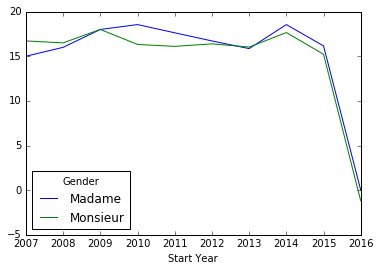

In [17]:
stats_df.plot()